In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.regression import linear_model
from sklearn.metrics import explained_variance_score
%matplotlib inline

seed(888)

# Load data

In [31]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("3_brain_test.pkl")
brain_train = pd.read_pickle("3_brain_train.pkl")
main_test = pd.read_pickle("3_main_test.pkl")
main_train = pd.read_pickle("3_main_train.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)

pd.set_option('display.max_columns', None)

# Recode variables

In [32]:
main_test['Imaging site'] = main_test['Imaging site'].map({'Cheadle': 1, 'Reading': 2,'Newcastle': 3, 'Bristol': 4})
main_test["Smoking"] = main_test["Smoking"].map({"No":0, "Only occasionally":1, "Yes, on most or all days":2})
main_test["Gender"] = main_test["Gender"].map({"Female":0, "Male":1})
main_test["Job PA"] = main_test["Job PA"].map({"Never/rarely":0, "Sometimes":1, "Usually":2,"Always":3})
main_test["Walking speed"] = main_test["Walking speed"].map({"Slow pace":0, "Steady average pace":1, "Brisk pace":2})
main_test["Gender"] = main_test["Gender"].astype("int")
main_test["MVPA"] = main_test["Moderate PA"] + main_test["Vigorous PA"]*2

del main_test["BA Desikan Delta Corr"]
del main_test["BA Delta Corr"]
del main_test["BA ASEG Delta Corr"]

main_test = main_test.rename(columns={"BA A2009 Delta Corr": "BA", "Total PA":"TPA", "Light PA":"LPA", "Moderate PA": "MPA","Vigorous PA":"VPA", "ECG max workload":"ECGW", 
    "ECG max heart rate":"ECGH","Townsend deprivation":"SES", "SR Walking PA":"SRLPA", "SR Moderate PA":"SRMPA", "SR Vigorous PA":"SRVPA",
     "Heart rate":"HR","Hand grip R":"HGR", "Imaging site":"IS", "Fluid intelligence":"FI", "S Blood pressure":"SBP", "D Blood pressure":"DBP", "Mental disorder":"MD", "Job PA":"JPA"})

main_test = pd.DataFrame(main_test)


# Simple correlation heatmap

Text(0.5, 1.0, 'Correlations All')

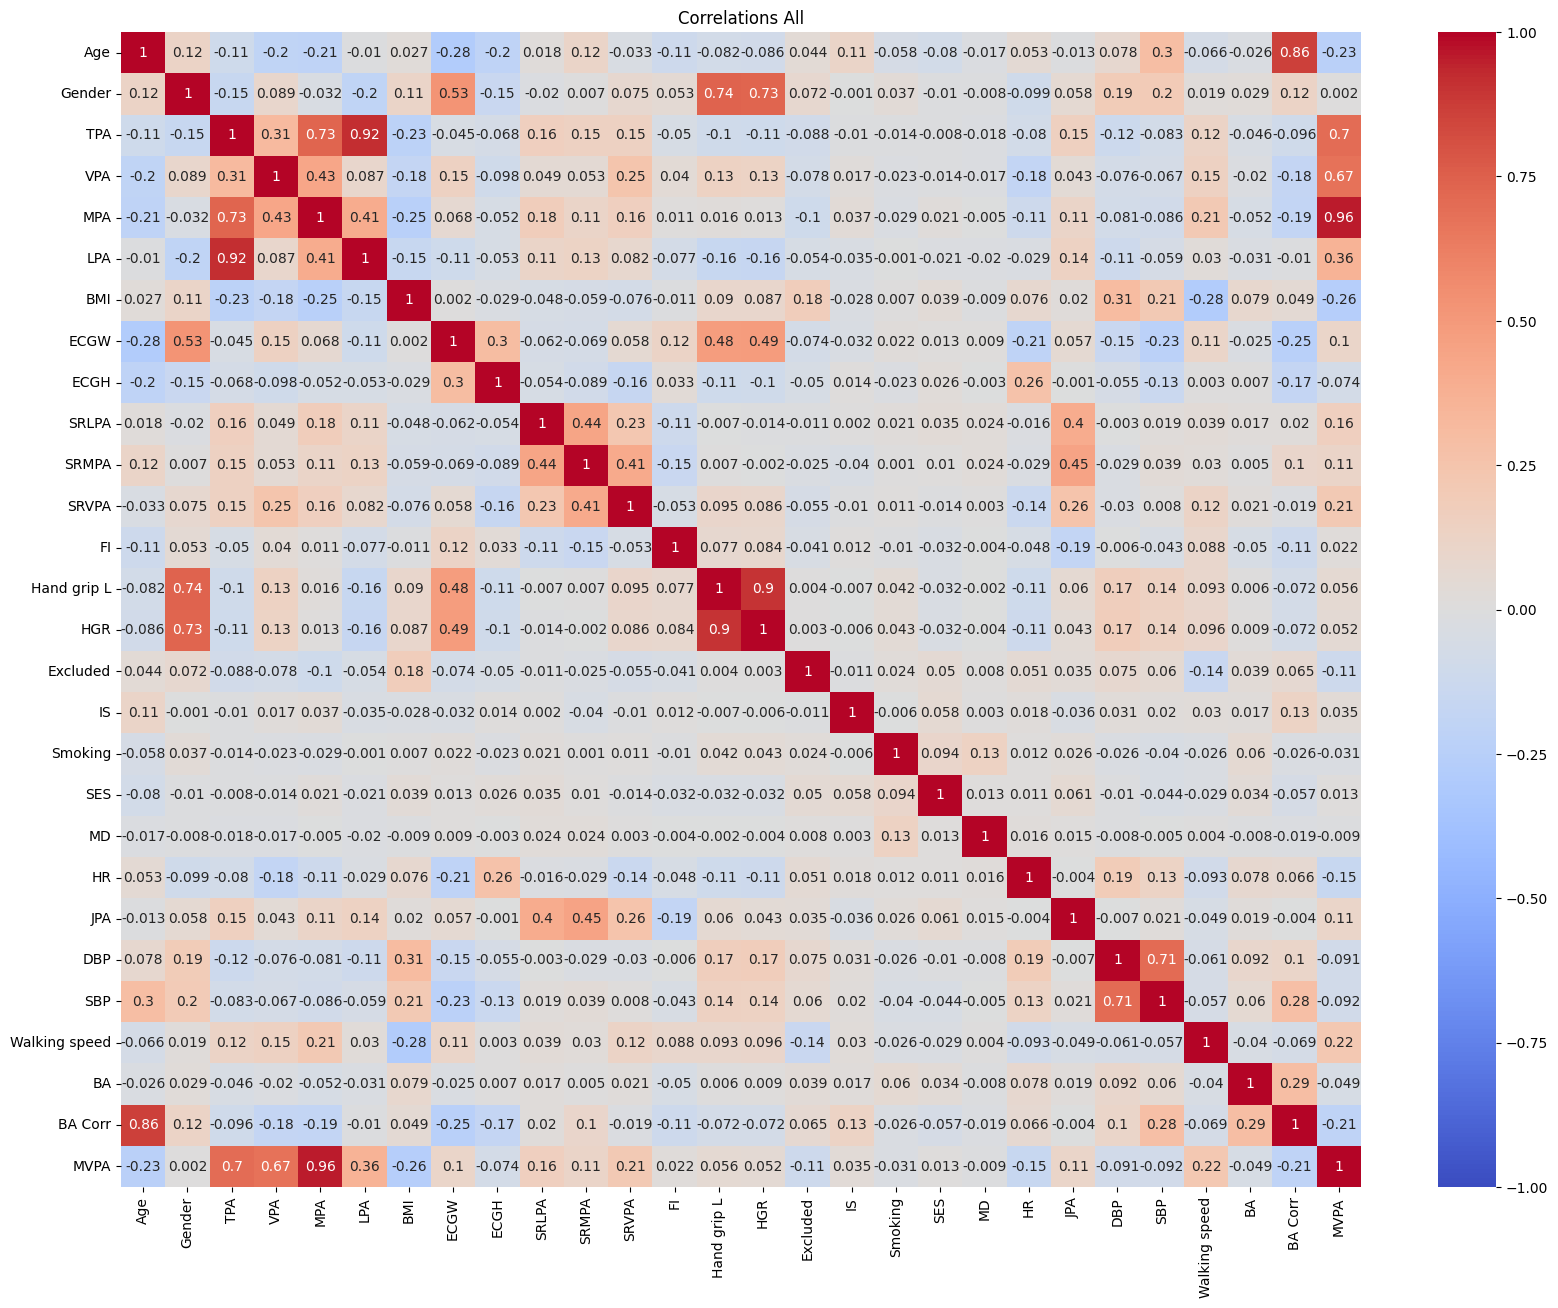

In [33]:
corr = main_test.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)
plt.title("Correlations All")

# Partial correlation heatmap

Text(0.5, 1.0, 'Correlations All')

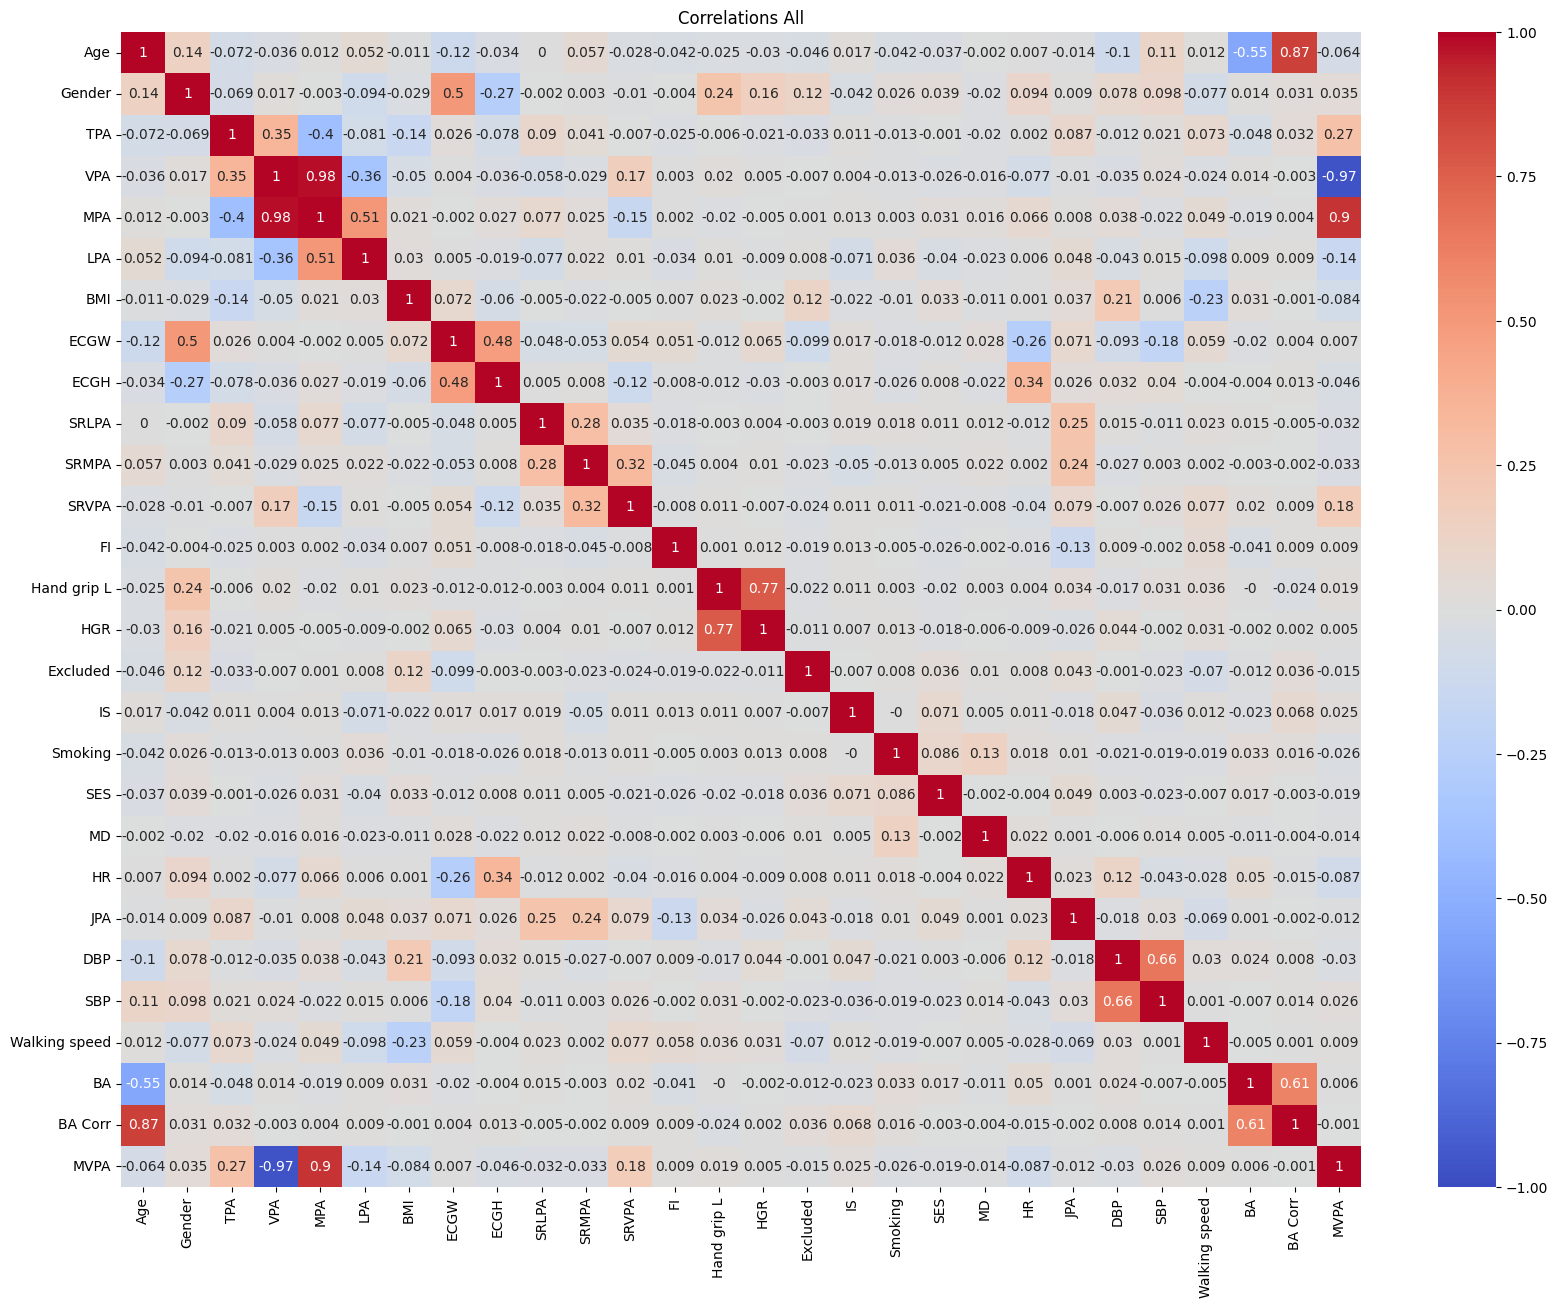

In [34]:
main_test_2 = main_test
#del main_test_2["Age"]
corr = main_test_2.pcorr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)
plt.title("Correlations All")

# Quartile box plot

168
105


{'whiskers': [<matplotlib.lines.Line2D at 0x7f2618e0e340>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2618e0e820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2618e19e50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2618e31d60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2618e252e0>,
 'means': []}

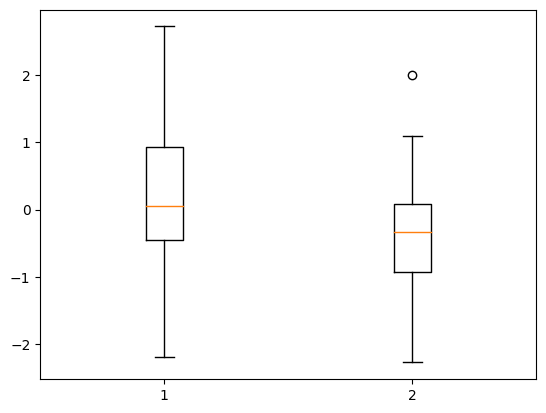

In [59]:
#main_test = main_test[main_test["Excluded"]==0]

# do the same with validation and exploration together (more data)
# do same thing with SR
#main_test = main_test["Gender"]==1

quartile_1_pa = np.percentile(main_test["MVPA"], 10)
quartile_4_pa = np.percentile(main_test["MVPA"], 90)
quartile_1_hg = np.nanpercentile(main_test["HGR"], 30)
quartile_4_hg = np.nanpercentile(main_test["HGR"], 70)
quartile_1_fi = np.nanpercentile(main_test["DBP"], 30)
quartile_4_fi = np.nanpercentile(main_test["DBP"], 70)

main_test_q1 = main_test[main_test["MVPA"]<quartile_1_pa ] 
main_test_q4 = main_test[main_test["MVPA"]>quartile_4_pa] 

main_test_q1 = main_test_q1[main_test_q1["HGR"]<quartile_1_hg]
main_test_q4 = main_test_q4[main_test_q4["HGR"]>quartile_4_hg]

main_test_q1 = main_test_q1[main_test_q1["DBP"]>quartile_4_fi]
main_test_q4 = main_test_q4[main_test_q4["DBP"]<quartile_1_fi]



main_test_q1 = main_test_q1[["DBP","FI", "BA"]]
main_test_q4 = main_test_q4[["DBP","FI", "BA"]]

main_test_q1 = main_test_q1.dropna(axis=0)
main_test_q4 = main_test_q4.dropna(axis=0)


print(main_test_q1.size)
print(main_test_q4.size)


plt.boxplot(x = [main_test_q1["BA"],main_test_q4["BA"]])



# Boxplot comparing groups

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2618d02c70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2618d0e820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2618d02850>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2618d194f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2618d19a90>,
 'means': []}

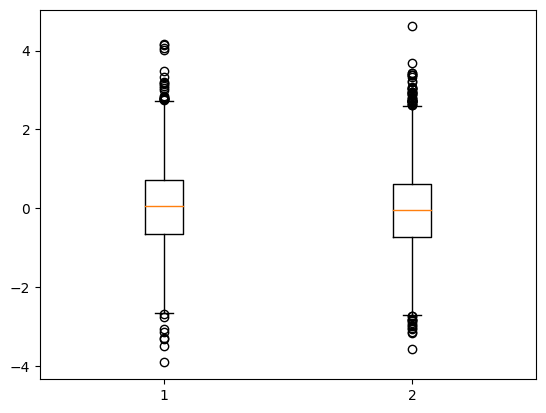

In [60]:
mental = main_test[main_test["Excluded"]==1]
no_mental = main_test[main_test["Excluded"] == 0]
plt.boxplot(x=[mental["BA"],no_mental["BA"]])

# Partial correlations with Covariates

In [37]:
cov_correlation = pg.partial_corr(data=main_test, x='SRLPA', y='BA', covar=["Gender", "IS", "Age"])
print("Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRMPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRVPA', y='BA', covar=["Gender", "IS", "Age"])
print("Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='TPA', y='BA', covar=["Gender", "IS", "Age"])
print("Total PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MVPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate+Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='LPA', y='BA', covar=["Gender", "IS", "Age"])
print("Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='VPA', y='BA', covar=["Gender", "IS", "Age"])
print("Vigorous PA")
print(cov_correlation)

Light PA
            n         r         CI95%     p-val
pearson  7156  0.018635  [-0.0, 0.04]  0.115042
Moderate PA
            n         r          CI95%     p-val
pearson  7156  0.009238  [-0.01, 0.03]  0.434715
Vigorous PA
            n         r          CI95%     p-val
pearson  7156  0.018059  [-0.01, 0.04]  0.126719
Total PA
            n         r           CI95%     p-val
pearson  8357 -0.044461  [-0.07, -0.02]  0.000048
Moderate+Vigorous PA
            n         r           CI95%         p-val
pearson  8357 -0.059556  [-0.08, -0.04]  5.109546e-08
Light PA
            n         r          CI95%     p-val
pearson  8357 -0.024654  [-0.05, -0.0]  0.024237
Moderate PA
            n         r           CI95%         p-val
pearson  8357 -0.060284  [-0.08, -0.04]  3.503757e-08
Vigorous PA
            n         r           CI95%     p-val
pearson  8357 -0.030592  [-0.05, -0.01]  0.005169


# Model Covariates

In [38]:
cov_model = ols('BA ~ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(cov_model.summary())

#calculate effect size
results = cov_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.054
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.66e-07
Time:                        14:11:02   Log-Likelihood:                -28267.
No. Observations:                8357   AIC:                         5.655e+04
Df Residuals:                    8350   BIC:                         5.660e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8470      1.551      3.769      0.0

# Model Acc PA

In [39]:
main_test["MPA"] = stats.zscore(main_test['MPA'], nan_policy='omit')
main_test["VPA"] = stats.zscore(main_test['VPA'], nan_policy='omit')
main_test["LPA"] = stats.zscore(main_test['LPA'], nan_policy='omit')
main_test["BA"] = stats.zscore(main_test['BA'], nan_policy='omit')
main_test["Age"] = stats.zscore(main_test['Age'], nan_policy='omit')

print(main_test.shape)

pa_model = ols('BA ~ LPA + MPA + VPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_model.summary())

#calculate effect size
results = pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

(8357, 28)
                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.114
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           4.41e-12
Time:                        14:11:02   Log-Likelihood:                -11822.
No. Observations:                8357   AIC:                         2.366e+04
Df Residuals:                    8347   BIC:                         2.373e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0298      0.033     -0.9

# Model all PA

In [40]:
main_test["SRMPA"] = stats.zscore(main_test['SRMPA'], nan_policy='omit')
main_test["SRVPA"] = stats.zscore(main_test['SRVPA'], nan_policy='omit')
main_test["SRLPA"] = stats.zscore(main_test['SRLPA'], nan_policy='omit')
sr_pa_model = ols('BA ~ SRLPA + SRMPA + SRVPA +LPA + MPA + VPA+ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_pa_model.summary())
results = sr_pa_model
coefficients = results.params
t_stats = results.tvalues

#calculate effect size
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.832
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           3.66e-10
Time:                        14:11:02   Log-Likelihood:                -10115.
No. Observations:                7156   AIC:                         2.026e+04
Df Residuals:                    7143   BIC:                         2.035e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0450      0.036     -1.255      0.2

# Model SR PA

In [41]:
sr_model = ols('BA ~ SRLPA + SRMPA + SRVPA +Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_model.summary())

#calculate effect size
results = sr_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.660
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           3.51e-06
Time:                        14:11:03   Log-Likelihood:                -10129.
No. Observations:                7156   AIC:                         2.028e+04
Df Residuals:                    7146   BIC:                         2.035e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0408      0.036     -1.141      0.2

# Model comparison Cov - PA & Cov - SR

In [42]:
model_comparison = anova_lm(cov_model, pa_model)
print(model_comparison)

   df_resid            ssr  df_diff        ss_diff              F  Pr(>F)
0    8350.0  424155.388689      0.0            NaN            NaN     NaN
1    8347.0    8284.518920      3.0  415870.869769  139669.109876     0.0


In [43]:
model_comparison = anova_lm(cov_model, sr_model)
print(model_comparison)

   df_resid            ssr  df_diff        ss_diff           F  Pr(>F)
0    8350.0  424155.388689      0.0            NaN         NaN     NaN
1    7146.0    7106.093135   1204.0  417049.295554  348.331718     0.0


# Model comparison SR & Acc & Both

In [44]:
model_comparison = anova_lm(pa_model, sr_pa_model)
print(model_comparison)

   df_resid         ssr  df_diff      ss_diff         F    Pr(>F)
0    8347.0  8284.51892      0.0          NaN       NaN       NaN
1    7143.0  7078.44945   1204.0  1206.069471  1.010854  0.399065


In [45]:
model_comparison = anova_lm(sr_model, sr_pa_model)
print(model_comparison)

   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0    7146.0  7106.093135      0.0        NaN       NaN       NaN
1    7143.0  7078.449450      3.0  27.643685  9.298592  0.000004


# Model Health and Fitness

In [46]:
results = ols('BA ~ HGR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     11.41
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.22e-19
Time:                        14:11:06   Log-Likelihood:                -9295.2
No. Observations:                6579   AIC:                         1.861e+04
Df Residuals:                    6568   BIC:                         1.869e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9292      0.129     -7.223      0.0

In [47]:
results = ols('BA ~ HGR + HR + DBP + FI + MPA + Age + IS', missing='drop', data = main_test).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     10.14
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.17e-12
Time:                        14:11:06   Log-Likelihood:                -6630.3
No. Observations:                4680   AIC:                         1.328e+04
Df Residuals:                    4672   BIC:                         1.333e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6664      0.148     -4.513      0.0

In [48]:
results = ols('BA ~ MPA + Age + IS + Gender + Gender:Age + Gender:IS + IS:Age', missing='drop', data = main_test).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.39
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           4.71e-13
Time:                        14:11:07   Log-Likelihood:                -11822.
No. Observations:                8357   AIC:                         2.366e+04
Df Residuals:                    8349   BIC:                         2.372e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0284      0.032     -0.878      0.3

In [49]:
results = ols('BA ~ MPA + DBP + Age + SES + Smoking +  HR + Excluded + IS + Gender + Gender:Age + Gender:IS + IS:Age', missing='drop', data = main_test).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     12.87
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.58e-26
Time:                        14:11:07   Log-Likelihood:                -9294.8
No. Observations:                6592   AIC:                         1.862e+04
Df Residuals:                    6579   BIC:                         1.870e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9555      0.117     -8.173      0.0

In [50]:
results = ols('BA ~ MPA', missing='drop', data = main_test).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     23.04
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.62e-06
Time:                        14:11:07   Log-Likelihood:                -11847.
No. Observations:                8357   AIC:                         2.370e+04
Df Residuals:                    8355   BIC:                         2.371e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.188e-18      0.011  -1.09e-16      1.0

# Moderation analysis Acc PA and Fitness / Health

In [51]:
#regression of x on m
model1 = ols('BMI ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ BMI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['BMI']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.019728912963886614
Direct effect: -0.03270759640916597
Total effect: -0.05243650937305258


In [52]:
#regression of x on m
model1 = ols('DBP ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ DBP',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['DBP']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.007439092758388978
Direct effect: -0.0449974166146636
Total effect: -0.05243650937305258


In [53]:
#regression of x on m
model1 = ols('HR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.00852220739848652
Direct effect: -0.04391430197456606
Total effect: -0.05243650937305258


# Mediation analysis Self-report - Job PA - Fluid intelligence

In [54]:
#regression of x on m
model1 = ols('FI ~ SRMPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRMPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRMPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRMPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.007450885014156709
Direct effect: -0.0028713553939755014
Total effect: 0.004579529620181207


In [55]:
#regression of x on m
model1 = ols('FI ~ SRVPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRVPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRVPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRVPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.0027015075375662824
Direct effect: 0.018465476427408492
Total effect: 0.021166983964974774


In [56]:
#regression of x on m
model1 = ols('FI ~ JPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ JPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['JPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['JPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.013058836047159468
Direct effect: 0.012178386857147026
Total effect: 0.025237222904306494


To Do for Scripts

- Clean up Brain Age and Preprocessing script
- Make one Preprocessing & BrainAge script (only with important segmentations) for validation set
- One final analysis script with seperate section for exploration and validation data and one section comparing the two and doing boxplot together